# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
from scipy.stats import linregress
import scipy.stats as st

# Import API key
from config import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Creating a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

#Identifying nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    #If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Printing the city count to confirm sufficient count
print(f" We are going to be analyzing {len(cities)} different cities")

 We are going to be analyzing 617 different cities


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:

columns = ['City', 'Lat', 'Lng', 'Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed', 'Country', 'Date']
weather_df = pd.DataFrame(columns=columns)

for city in cities:
    
    #get the json 
    url = f"http://api.openweathermap.org/data/2.5/weather?appid={api_key}&q={city}&units=imperial"
    response = requests.get(url).json()
    
    #adding the data from the json into the empty weather_df dataframe
    try:
        
        print(f"Processing {city.title()}  ID: {response['id']} ")
        print(f"----------.----------.----------.----------.--")
        
        weather_df = weather_df.append({
                    'City': response['name'],
                    'Lat': response['coord']['lat'],
                    'Lng': response['coord']['lon'],
                    'Max Temp': response['main']['temp_max'],
                    'Humidity': response['main']['humidity'],
                    'Cloudiness': response['clouds']['all'],
                    'Wind Speed': response['wind']['speed'],
                    'Country': response['sys']['country'],
                    'Date': response['dt']},
                    ignore_index=True)  
        
    except:
        print(f"********** {city.title()} is unavailable ***********")
        print(f"----------.----------.----------.----------.--")
        

Processing Mishelevka  ID: 2019945 
----------.----------.----------.----------.--
Processing Klaksvik  ID: 2618795 
----------.----------.----------.----------.--
********** Sentyabrskiy is unavailable ***********
----------.----------.----------.----------.--
Processing Yanam  ID: 1252795 
----------.----------.----------.----------.--
Processing Mahebourg  ID: 934322 
----------.----------.----------.----------.--
Processing Camacha  ID: 2270385 
----------.----------.----------.----------.--
********** Taolanaro is unavailable ***********
----------.----------.----------.----------.--
Processing Lucea  ID: 3489657 
----------.----------.----------.----------.--
Processing Portland  ID: 5746545 
----------.----------.----------.----------.--
Processing Pevek  ID: 2122090 
----------.----------.----------.----------.--
Processing Bella Union  ID: 3443631 
----------.----------.----------.----------.--
Processing Busselton  ID: 2075265 
----------.----------.----------.----------.--
P

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
#exporting my dataframe to a csv 
weather_df.to_csv(output_data_file, index=False)

In [6]:
weather_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Mishelevka,52.8575,103.1719,-3.89,91,100,3.58,RU,1612310543
1,Klaksvík,62.2266,-6.5890,32.00,86,20,5.75,FO,1612310543
2,Yanam,16.7333,82.2167,65.01,80,0,2.71,IN,1612310544
3,Mahébourg,-20.4081,57.7000,78.80,78,40,6.91,MU,1612310544
4,Camacha,33.0833,-16.3333,62.60,77,75,2.30,PT,1612310544
...,...,...,...,...,...,...,...,...,...
562,Roald,62.5833,6.1333,24.80,74,0,10.36,NO,1612310617
563,Kuril'sk,45.2333,147.8833,12.99,89,100,31.65,RU,1612310617
564,Riyadh,24.6877,46.7219,60.80,31,0,5.75,SA,1612310499
565,Buenos Aires,-34.6132,-58.3772,73.99,78,40,8.05,AR,1612310481


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
if len(weather_df[ weather_df.loc[:,'Humidity'] > 100 ]) < 1:
    
    print('***********************************************************')
    print('There are no cities that display humidity greater than 100%')
    print('***********************************************************')
    
else:
    
    weather_df.drop(weather_df[weather_df.loc[:,'Humidity'] > 100],inplace=True)

***********************************************************
There are no cities that display humidity greater than 100%
***********************************************************


In [8]:
# Making a new DataFrame equal to the city data to drop all humidity outliers by index.
#reading my new csv file that I created from the API requests
cities_df = pd.read_csv(output_data_file)

In [9]:
humidity = cities_df["Humidity"]

#quartiles and iqr for humidity in order to find and drop the outliers
quartiles = humidity.quantile([.25, .5, .75])
lower_quartile = quartiles[.25]
upper_quartile = quartiles[.75]
iqr = upper_quartile - lower_quartile

lower = lower_quartile - (1.5 * iqr)
upper = upper_quartile + (1.5 * iqr)

outliers = cities_df[ (cities_df['Humidity'] < lower) | (cities_df['Humidity'] > upper) ] ['Humidity']

#creating new clean dataframe without humidity outliers
clean_city_data = cities_df.drop(outliers.index,inplace=False)

clean_city_data

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Mishelevka,52.8575,103.1719,-3.89,91,100,3.58,RU,1612310543
1,Klaksvík,62.2266,-6.5890,32.00,86,20,5.75,FO,1612310543
2,Yanam,16.7333,82.2167,65.01,80,0,2.71,IN,1612310544
3,Mahébourg,-20.4081,57.7000,78.80,78,40,6.91,MU,1612310544
4,Camacha,33.0833,-16.3333,62.60,77,75,2.30,PT,1612310544
...,...,...,...,...,...,...,...,...,...
561,Oussouye,12.4850,-16.5469,75.20,94,0,2.30,SN,1612310617
562,Roald,62.5833,6.1333,24.80,74,0,10.36,NO,1612310617
563,Kuril'sk,45.2333,147.8833,12.99,89,100,31.65,RU,1612310617
565,Buenos Aires,-34.6132,-58.3772,73.99,78,40,8.05,AR,1612310481


In [119]:
## Plotting the Data
# Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
# Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

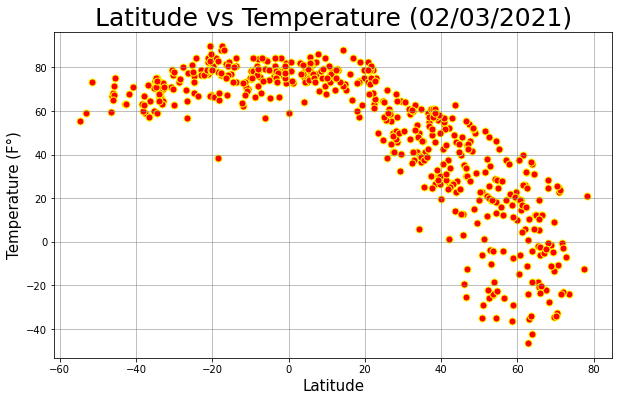

In [10]:
x_lat = []
y_tmp = []
size = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for i in clean_city_data.index:
    x_lat.append(clean_city_data.loc[i,'Lat'])
    y_tmp.append(clean_city_data.loc[i,'Max Temp'])

plt.figure(figsize=(10,6))
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.5)
plt.scatter(x_lat, y_tmp , marker='o', facecolors='red', edgecolor='yellow', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Temperature ({date_of_temp})", size=25)
plt.xlabel('Latitude', size=15)
plt.ylabel('Temperature (F°)', size=15)
plt.savefig('../output_data/Latitude_vs_Temp_20210202.png')
plt.show()

## Latitude vs. Humidity Plot

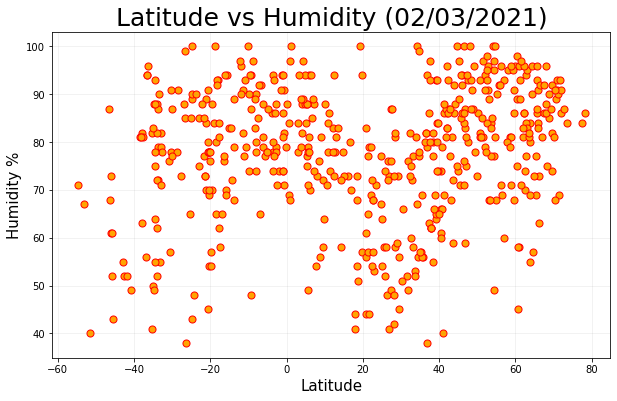

In [11]:
x_lat = []
y_hum = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for i in clean_city_data.index:
    x_lat.append(clean_city_data.loc[i,'Lat'])
    y_hum.append(clean_city_data.loc[i,'Humidity'])
    
plt.figure(figsize=(10,6))
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat, y_hum , marker='o', facecolors='orange', edgecolor='red', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Humidity ({date_of_temp})", size=25)
plt.xlabel('Latitude', size=15)
plt.ylabel('Humidity %', size=15)
plt.savefig('../output_data/Latitude_vs_Humidity_20210202.png')
plt.show()

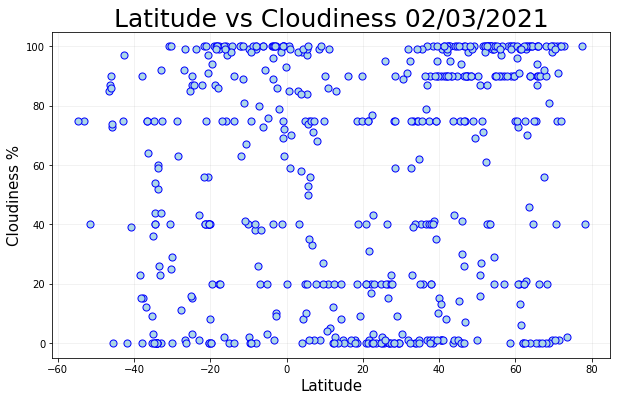

In [12]:
## Latitude vs. Cloudiness Plot
x_lat = []
y_cld = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for i in clean_city_data.index:
    x_lat.append(clean_city_data.loc[i,'Lat'])
    y_cld.append(clean_city_data.loc[i,'Cloudiness'])
    
plt.figure(figsize=(10,6))
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat, y_cld , marker='o', facecolors='lightblue', edgecolor='blue', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Cloudiness {date_of_temp}", size=25)
plt.xlabel('Latitude', size=15)
plt.ylabel('Cloudiness %', size=15)
plt.savefig('../output_data/Latitude_vs_Cloudiness_20210202.png')
plt.show()

## Latitude vs. Wind Speed Plot

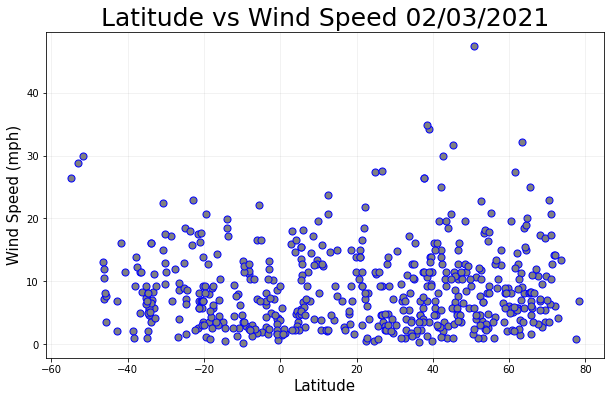

In [13]:
## Latitude vs. Cloudiness Plot
x_lat = []
y_wnd = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for i in clean_city_data.index:
    x_lat.append(clean_city_data.loc[i,'Lat'])
    y_wnd.append(clean_city_data.loc[i,'Wind Speed'])
    
plt.figure(figsize=(10,6))
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat, y_wnd , marker='o', facecolors='grey', edgecolor='blue', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Wind Speed {date_of_temp}", size=25)
plt.xlabel('Latitude', size=15)
plt.ylabel('Wind Speed (mph)', size=15)
plt.savefig('../output_data/Latitude_vs_WindSpeed_20210202.png')
plt.show()

## Linear Regression

The rvalue is -0.8442151791758994


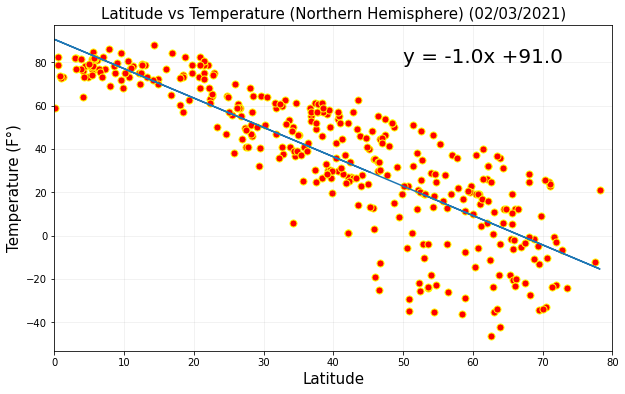

In [14]:
####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

x_lat_northern_hem = []
y_tmp_northern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] > 0].iterrows():
    x_lat_northern_hem.append(row['Lat'])
    y_tmp_northern_hem.append(row['Max Temp'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_northern_hem, y_tmp_northern_hem)
line = [(i * slope) + intercept for i in x_lat_northern_hem]
equation = "y = " + str(round(slope)) + "x +" + str(round(intercept))

print(f"The rvalue is {rvalue}")
plt.figure(figsize=(10,6))
plt.xlim(0, 80)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_northern_hem, y_tmp_northern_hem , marker='o', facecolors='red', edgecolor='yellow', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Temperature (Northern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Temperature (F°)', size=15)
plt.plot(x_lat_northern_hem, line)
plt.annotate(equation, (50,80), fontsize = 20, color = 'black')
plt.savefig('../output_data/Latitude_vs_Temperature_northen_hemisphere_linregress_20210202.png')
plt.show()

The rvalue is 0.4772735466132208


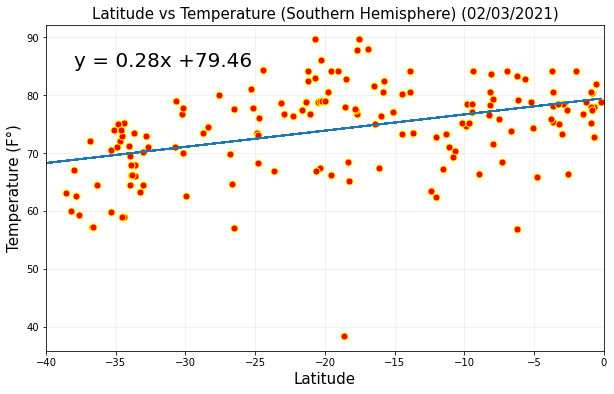

In [15]:
####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression
x_lat_southern_hem = []
y_tmp_southern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] < 0].iterrows():
    x_lat_southern_hem.append(row['Lat'])
    y_tmp_southern_hem.append(row['Max Temp'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_southern_hem, y_tmp_southern_hem)
line = [(i * slope) + intercept for i in x_lat_southern_hem]
equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

print(f"The rvalue is {rvalue}")

plt.figure(figsize=(10,6))
plt.xlim(-40, 0)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_southern_hem, y_tmp_southern_hem , marker='o', facecolors='red', edgecolor='yellow', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Temperature (Southern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Temperature (F°)', size=15)
plt.plot(x_lat_southern_hem, line)
plt.annotate(equation, (-38,85), fontsize = 20, color = 'black')
plt.savefig('../output_data/Latitude_vs_Temperature_southern_hemisphere_linregress_20210202.png')
plt.show()

The rvalue is 0.2612538241178883


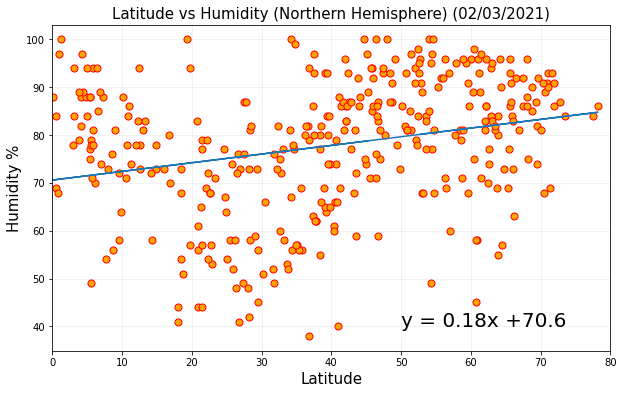

In [16]:
####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
x_lat_northern_hem = []
y_hum_northern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] > 0].iterrows():
    x_lat_northern_hem.append(row['Lat'])
    y_hum_northern_hem.append(row['Humidity'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_northern_hem, y_hum_northern_hem)
line = [(i * slope) + intercept for i in x_lat_northern_hem]
equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

print(f"The rvalue is {rvalue}")

plt.figure(figsize=(10,6))
plt.xlim(0, 80)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_northern_hem, y_hum_northern_hem , marker='o', facecolors='orange', edgecolor='red', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Humidity (Northern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Humidity %', size=15)
plt.plot(x_lat_northern_hem, line)
plt.annotate(equation, (50,40), fontsize = 20, color = 'black')
plt.savefig('../output_data/Latitude_vs_Humidity_northern_hemisphere_linregress_20210202.png')
plt.show()

The rvalue is 0.3715856049400635


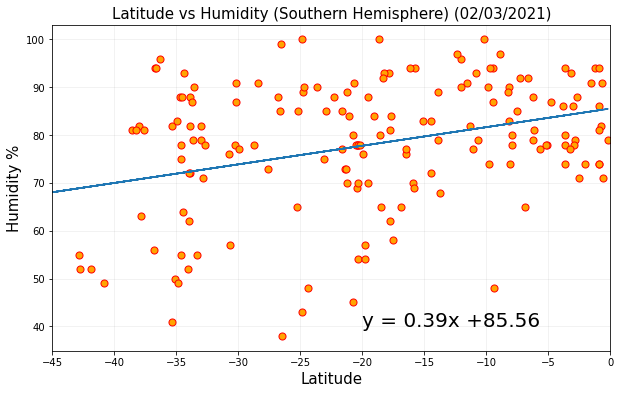

In [17]:
####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
x_lat_southern_hem = []
y_hum_southern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] < 0].iterrows():
    x_lat_southern_hem.append(row['Lat'])
    y_hum_southern_hem.append(row['Humidity'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_southern_hem, y_hum_southern_hem)
line = [(i * slope) + intercept for i in x_lat_southern_hem]
equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

print(f"The rvalue is {rvalue}")

plt.figure(figsize=(10,6))
plt.xlim(-45, 0)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_southern_hem, y_hum_southern_hem , marker='o', facecolors='orange', edgecolor='red', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Humidity (Southern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Humidity %', size=15)
plt.plot(x_lat_southern_hem, line)
plt.annotate(equation, (-20,40), fontsize = 20, color = 'black')
plt.savefig('../output_data/Latitude_vs_Humidity_southern_hemisphere_linregress_20210202.png')
plt.show()

The rvalue is 0.267209163545928


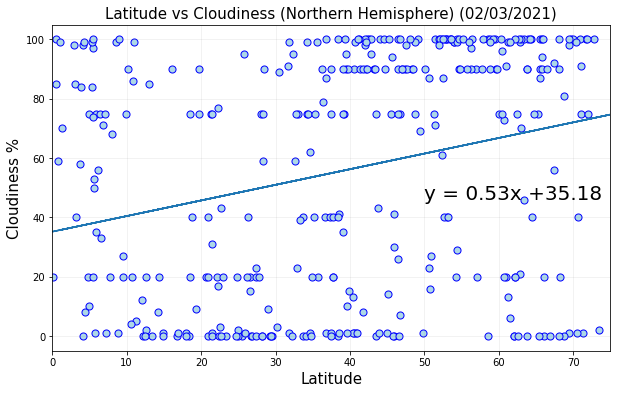

In [18]:
#  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
x_lat_northern_hem = []
y_cld_northern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] > 0].iterrows():
    x_lat_northern_hem.append(row['Lat'])
    y_cld_northern_hem.append(row['Cloudiness'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_northern_hem, y_cld_northern_hem)
line = [(i * slope) + intercept for i in x_lat_northern_hem]
equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

print(f"The rvalue is {rvalue}")

plt.figure(figsize=(10,6))


plt.xlim(0, 75)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_northern_hem, y_cld_northern_hem , marker='o', facecolors='lightblue', edgecolor='blue', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Cloudiness (Northern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Cloudiness %', size=15)
plt.plot(x_lat_northern_hem, line)
plt.annotate(equation, (50,46), fontsize = 20, color = 'black')
plt.savefig('../output_data/Latitude_vs_Cloudiness_northern_hemisphere_linregress_20210202.png')
plt.show()

The rvalue is 0.24972663046057184


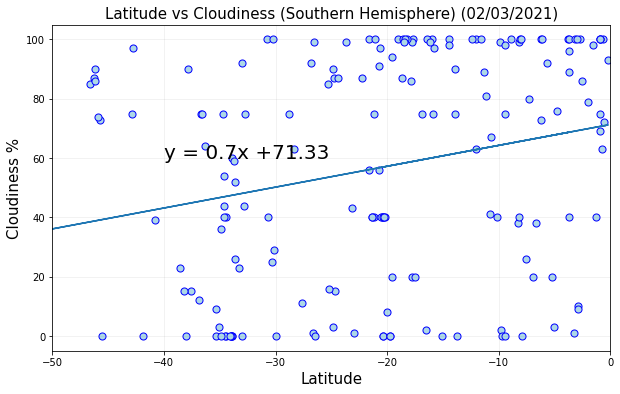

In [19]:
####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
x_lat_southern_hem = []
y_cld_southern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x, unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] < 0].iterrows():
    x_lat_southern_hem.append(row['Lat'])
    y_cld_southern_hem.append(row['Cloudiness'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_southern_hem, y_cld_southern_hem)
line = [(i * slope) + intercept for i in x_lat_southern_hem]
equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

print(f"The rvalue is {rvalue}")

plt.figure(figsize=(10,6))


plt.xlim(-50, 0)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_southern_hem, y_cld_southern_hem , marker='o', facecolors='lightblue', edgecolor='blue', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Cloudiness (Southern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Cloudiness %', size=15)
plt.plot(x_lat_southern_hem, line)
plt.savefig('../output_data/Latitude_vs_Cloudiness_southern_hemisphere_linregress_20210202.png')
plt.annotate(equation, (-40,60), fontsize = 20, color = 'black')
plt.show()

The rvalue is 0.05382226158800121


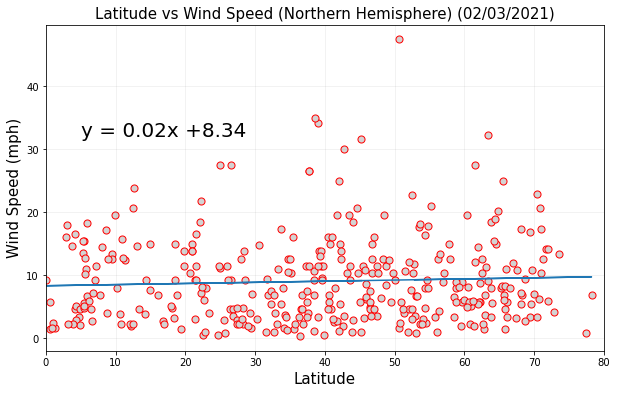

In [20]:
####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
x_lat_northern_hem = []
y_wnd_northern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] > 0].iterrows():
    x_lat_northern_hem.append(row['Lat'])
    y_wnd_northern_hem.append(row['Wind Speed'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_northern_hem, y_wnd_northern_hem)
line = [(i * slope) + intercept for i in x_lat_northern_hem]
equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

print(f"The rvalue is {rvalue}")

plt.figure(figsize=(10,6))
plt.xlim(0, 80)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_northern_hem, y_wnd_northern_hem , marker='o', facecolors='lightgrey', edgecolor='red', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Wind Speed (Northern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Wind Speed (mph)', size=15)
plt.plot(x_lat_northern_hem, line)
plt.annotate(equation, (5,32), fontsize = 20, color = 'black')
plt.savefig('../output_data/Latitude_vs_WindSpeed_northern_hemisphere_linregress_20210202.png')
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The rvalue is -0.27954216890412165


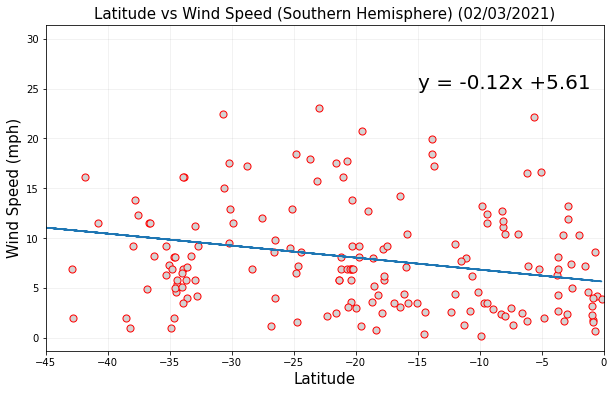

In [22]:
####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
x_lat_southern_hem = []
y_wnd_southern_hem = []

date_of_temp = clean_city_data.Date.apply(lambda x: pd.to_datetime(x,unit='s').strftime('%m/%d/%Y'))[0]

for index, row in clean_city_data[clean_city_data.loc[:,'Lat'] < 0].iterrows():
    x_lat_southern_hem.append(row['Lat'])
    y_wnd_southern_hem.append(row['Wind Speed'])

slope, intercept, rvalue, pvalue, stderr = st.linregress(x_lat_southern_hem, y_wnd_southern_hem)
line = [(i * slope) + intercept for i in x_lat_southern_hem]
equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

print(f"The rvalue is {rvalue}")

plt.figure(figsize=(10,6))
plt.xlim(-45, 0)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.1)
plt.scatter(x_lat_southern_hem, y_wnd_southern_hem , marker='o', facecolors='lightgrey', edgecolor='red', s=(50),  alpha=1.0)
plt.title(f"Latitude vs Wind Speed (Southern Hemisphere) ({date_of_temp})", size=15)
plt.xlabel('Latitude', size=15)
plt.ylabel('Wind Speed (mph)', size=15)
plt.plot(x_lat_southern_hem, line)
plt.annotate(equation, (-15,25), fontsize = 20, color = 'black')
plt.savefig('../output_data/Latitude_vs_WindSpeed_southern_hemisphere_linregress_20210202.png')
plt.show()